# Similarity Data Product

### In this notebook, we: 

##### 1. Import OHCO dataframe for our corpus and perform textual pre-processing
##### 2. Create a token and vocab table
##### 3. Create a DTM and TFIDF model, at an artist level 
##### 4. Calculate the Euclidean and Cosine similarities across artists
##### 5. Create a final dataframe ranked by the most similar artists


In [116]:
# Import libraries and upload OHCO (by line) #
import pandas as pd
import numpy as np
import os
#os.chdir('/Users/nickbruno/Documents/spring_2019/DS5559/project/code')

df = pd.read_csv('artist_song_verse_line_OHCO_df_FULL.csv') # includes corpus with no duplicate song names

### Selecting a random subset of 350 artists

##### We could not run this code on the full dataset due to computing constraints, even while utilizing Rivanna

In [117]:
artist_id_list = df.artist_id.unique().tolist()
import random
random.seed(100)
sub_artist = random.sample(artist_id_list, k=350)
#sub_artist=[261,490,496,500,406,424,580]
#sub_artist

In [118]:
# Subset to create smaller corpus #
subset_df = df[df.artist_id.isin(sub_artist)]

In [119]:
#Subset of 1,104,910 songs
len(subset_df)

1104910

### Creating a token table 

In [120]:
#settings multiple indices 
subset_df = subset_df.set_index(['artist_id','song_id','verse_num','line_num'])
subset_df.head()

Line
artist_id song_id verse_num line_num                                                   
1         113     0         0                                  Always have, always will
                            1                     I was mesmerized when I first met you
                            2                               Wouldn't let myself believe
                            3         That you could step right out of my wildest dr...
                            4                                       But you didn't know

In [121]:
# Create a bag of tokens #
TOKEN_PAT = r'(\W+)'
token_subset_df = subset_df.Line.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
token_subset_df.index.names = ['artist_id','song_id','verse_num','line_num','token_num']

In [122]:
# Remove numbers and punctuation #
token_subset_df['punc'] = token_subset_df.token_str.str.match(r'^[\W_]*$').astype('int')
token_subset_df['num'] = token_subset_df.token_str.str.match(r'\d').astype('int')

In [123]:
# Create subsets where punc and num == 0
no_punc = token_subset_df[token_subset_df.punc == 0]
no_num = no_punc[no_punc.num == 0]

In [124]:
no_num.token_str = no_num.token_str.str.lower()

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [125]:
# Remove stopwords #
from nltk.corpus import stopwords
stop = stopwords.words('english')
final_token_df = no_num[-no_num.token_str.isin(stop)]

In [127]:
final_token_df.head(10)

token_str  punc  num
artist_id song_id verse_num line_num token_num                       
1         113     0         0        0              always     0    0
                                     4              always     0    0
                            1        4          mesmerized     0    0
                                     10              first     0    0
                                     12                met     0    0
                            2        4                 let     0    0
                                     8             believe     0    0
                            3        4               could     0    0
                                     6                step     0    0
                                     8               right     0    0

In [128]:
final_token_df = final_token_df.drop(columns=['punc','num'])

In [129]:
df = final_token_df

### Removing stopwords and stemming the dataframe

In [130]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/kk4ze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kk4ze/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/kk4ze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/kk4ze/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kk4ze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
# Stem each word #
stemmer = nltk.stem.porter.PorterStemmer()
df['port_stem'] = df.token_str.apply(lambda x: stemmer.stem(x))

In [132]:
token_counts = df.port_stem.str.lower().value_counts()
token_counts

love           55808
know           43203
like           35760
oh             32778
go             29949
get            28617
got            28117
time           27522
come           26619
one            26422
want           24745
see            23206
babi           22251
let            21903
say            21412
never          21239
make           20491
feel           20464
way            19618
take           19552
yeah           18884
day            17883
heart          17341
caus           16221
back           15984
gonna          15053
away           15016
life           14962
night          14892
look           14857
               ...  
chevel             1
jumun              1
hatza              1
asch               1
quarterdeck        1
picutr             1
westwher           1
leganot            1
hamiliton          1
newsgroup          1
vertrouwen         1
plooker            1
paniwalaan         1
waraechau          1
hico               1
drooo              1
nadal        

### Creating the vocab table

In [133]:
vocab = df.port_stem.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'port_stem', 'port_stem':'n'})
vocab = vocab.sort_values('port_stem').reset_index()
vocab.index.name = 'term_id'
vocab = vocab.drop('index', 1)

In [134]:
vocab.sort_values('n', ascending=False).head(25)

,port_stem,n
term_id,,
22224,love,55808
20502,know,43203
21721,like,35760
26847,oh,32778
15213,go,29949
14844,get,28617
15425,got,28117
38710,time,27522
7443,come,26619


In [135]:
K = df
V = vocab

In [136]:
K['term_id'] = K['port_stem'].map(V.reset_index().set_index('port_stem').term_id).fillna(-1).astype('int')

## Creating the Bag-of-Words Model
#### We define our OHCO labels based on our index, selecting the artist_id OHCO for our analysis as we want to compare similarities across artists. We can change easily change our label to song_id, for instance, if we want to compare similarities at a song level.

In [137]:
OHCO = ['artist_id', 'song_id', 'verse_num', 'line_num','token_num']
ARTIST=OHCO[:1]

In [138]:
# Create a bag of words per song #
BOW = K.groupby(ARTIST+['term_id'])['term_id'].count()
BOW.head(10)

artist_id  term_id
1          85          1
           228         3
           244         4
           298         2
           300         4
           310         1
           313         1
           342         1
           431        11
           438         1
Name: term_id, dtype: int64

In [139]:
#Creating a Document-Term Matrix
DTM = BOW.unstack().fillna(0)
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,43892,43893,43894,43895,43896,43897,43898,43899,43900,43901
artist_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating the TF-IDF Dataframe

In [140]:
# Now creating the TFIDF table #
alpha = .000001 # We introduce an arbitrary smoothing value
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [141]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V['df'])

In [142]:
THM = -(TF * np.log2(TF))

In [143]:
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [144]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

In [145]:
V.sort_values(by='n', ascending=False)

,port_stem,n,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,
22224,love,55808,342,5.624025,1.606864e-02,0.095640,0.187610,5.360273e-04,0.003190,1.780558e+02,5.087308e-01,3.027949e+00,31.659853,0.090457,0.323860
20502,know,43203,345,4.423273,1.263792e-02,0.039757,0.091821,2.623451e-04,0.000825,1.203802e+02,3.439434e-01,1.081992e+00,27.215185,0.077758,0.184975
21721,like,35760,345,3.588677,1.025336e-02,0.053302,0.074496,2.128451e-04,0.001106,8.267232e+01,2.362066e-01,1.227921e+00,23.036990,0.065820,0.225450
26847,oh,32778,337,3.310437,9.458392e-03,0.090155,0.180771,5.164881e-04,0.004923,6.844648e+01,1.955614e-01,1.864038e+00,20.675966,0.059074,0.312968
15213,go,29949,343,2.980635,8.516101e-03,0.023134,0.086875,2.482132e-04,0.000674,5.977928e+01,1.707979e-01,4.639642e-01,20.055885,0.057303,0.125705
14844,get,28617,339,2.687270,7.677914e-03,0.020594,0.123802,3.537188e-04,0.000949,4.893348e+01,1.398099e-01,3.750055e-01,18.209364,0.052027,0.115360
15425,got,28117,336,2.656437,7.589821e-03,0.029562,0.156447,4.469925e-04,0.001741,4.771817e+01,1.363376e-01,5.310350e-01,17.963220,0.051323,0.150180
38710,time,27522,343,2.809121,8.026061e-03,0.021881,0.081876,2.339304e-04,0.000638,5.365885e+01,1.533110e-01,4.179669e-01,19.101650,0.054576,0.120657
7443,come,26619,344,2.761339,7.889541e-03,0.078251,0.068885,1.968153e-04,0.001952,5.180416e+01,1.480119e-01,1.468028e+00,18.760519,0.053601,0.287631


## Calculating the Eucledian and Cosine distances for similar artists

In [146]:
# Find significant words #
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).port_stem.head(10).tolist()

In [147]:
def get_songs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

In [148]:
D = get_songs(K, ARTIST, 'port_stem', sep=" ")\
    .to_frame().rename(columns={'port_stem':'song_str'})

In [149]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [150]:
D.head()

,song_str,term_count,tf
artist_id,,,
1,alway alway mesmer first met let believ could ...,8433,0.002475
3,vers leav heart door say word said know play p...,6666,0.001957
4,love miss lovin kiss miss kissin love miss lov...,19833,0.005822
5,certain face springtim flower stood paid due f...,15019,0.004409
6,go away one belong glad met stay though long d...,3109,0.000913


In [151]:
song_ids = D.index.tolist()
pairs = [(i,j) for i in song_ids for j in song_ids if j > i]

In [152]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [153]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [154]:
P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

In [155]:
P['euclidean_sim'] = 1 / (P.euclidean + 1)
PME = P.euclidean.unstack().fillna(0)
PME.head()

doc_y,3,4,5,6,7,8,10,11,12,13,...,624,626,630,631,633,634,635,639,640,641
doc_x,,,,,,,,,,,,,,,,,,,,,
1,0.072858,0.062081,0.062332,0.201487,0.063459,0.069859,0.064138,0.073157,0.059136,0.063783,...,0.074447,0.062854,0.104386,0.191764,0.086238,0.120978,0.170256,0.143415,0.101562,0.113334
3,0.000000,0.053505,0.053071,0.200000,0.054745,0.062345,0.056378,0.066246,0.048986,0.055101,...,0.062701,0.053481,0.099677,0.189110,0.079692,0.116362,0.167544,0.141564,0.095944,0.108531
4,0.000000,0.000000,0.037603,0.196247,0.038748,0.049279,0.040342,0.053614,0.031519,0.038656,...,0.055379,0.037292,0.092129,0.184788,0.070312,0.110168,0.162887,0.136161,0.088731,0.101642
5,0.000000,0.000000,0.000000,0.196273,0.033030,0.048871,0.041722,0.054460,0.031109,0.039841,...,0.055154,0.037984,0.092178,0.185293,0.069920,0.110066,0.163122,0.136268,0.088162,0.101321
6,0.000000,0.000000,0.000000,0.000000,0.196669,0.199120,0.197334,0.199106,0.195424,0.196860,...,0.200476,0.196681,0.213076,0.267016,0.205321,0.222123,0.251610,0.236204,0.212274,0.217970


In [156]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    
#     a = np.sqrt(D1.sum()**2)     # <-- misplaced exponent!
#     b = np.sqrt(D2.sum()**2)     # <-- misplaced exponent!
#     c = np.sqrt(a) * np.sqrt(b)  # <-- extra square roots!

    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    
    z = y / c
    return z

In [157]:
from numpy.linalg import norm
def cosine_np(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return np.dot(D1, D2)/(norm(D1)*norm(D2))

from scipy import spatial
def cosine_scipy(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return (1 - spatial.distance.cosine(D1, D2))

from sklearn.metrics.pairwise import cosine_similarity
def cosine_sklearn(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return cosine_similarity([TFIDF.loc[0]], [TFIDF.loc[1]])[0][0]

In [158]:
P['cosine'] = P.apply(cosine_scipy, 1)

P.head()

euclidean  euclidean_sim    cosine
doc_x doc_y                                    
1     3       0.072858       0.932090  0.026536
      4       0.062081       0.941548  0.059273
      5       0.062332       0.941325  0.033809
      6       0.201487       0.832302  0.026364
      7       0.063459       0.940328  0.042749

### Here are the most similar artists, visualized. We will take a deeper look at this later.

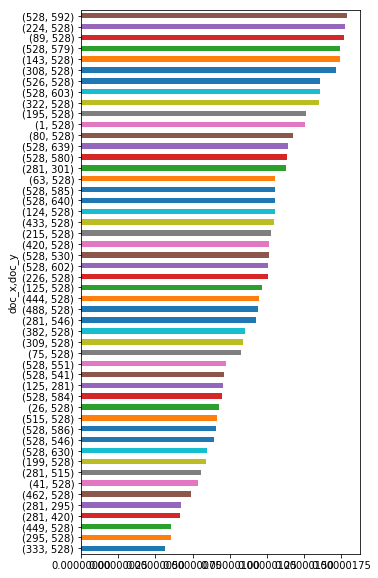

In [159]:
PMC = P.cosine.unstack().fillna(0)
PMC.head()
P.cosine.sort_values(ascending=True).head(50).plot(kind='barh', figsize=(5,10))

### All good until here. Now we want to find which artists are most similar to other artists at a more detailed level

In [191]:
# Create a dataframe that unstacks PMC #
pmc_df = PMC.unstack()
pmc_df = pd.DataFrame(pmc_df)
pmc_df.doc_y = pmc_df.index
pmc_df = pmc_df.reset_index(level=['doc_y', 'doc_x'])
pmc_df = pmc_df.rename(columns={0:'Similarity'})

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [192]:
pmc_df.shape[0] # number of similaritiese to compare

121801

In [193]:
len(pmc_df.doc_y.unique()) # 349 different artists

349

In [194]:
#Creating a dataframe for every artist to artist similarity mapping 

pmc_df_new = pmc_df
pmc_df_new.columns = ['doc_x','doc_y','Similarity']
pmc_df_merge = pmc_df.append(pmc_df_new)

In [197]:
pmc_df_merge.head()

,doc_x,doc_y,Similarity
0,3,1,0.026536
1,3,3,0.000000
2,3,4,0.000000
3,3,5,0.000000
4,3,6,0.000000


In [202]:
highest_sim = pmc_df_merge.groupby('doc_y')[['Similarity']].max().sort_values('Similarity',ascending=False)
highest_sim = highest_sim.reset_index(['doc_y'])
highest_sim.tail()

,doc_y,Similarity
344,630,0.014022
345,584,0.009390
346,633,0.009382
347,639,0.008779
348,634,0.005443


In [203]:
highest_sim.shape[0]

349

In [204]:
sim_merge = pd.merge(highest_sim, pmc_df_merge, how='inner', on=['doc_y','Similarity'])

In [205]:
sim_merge.shape

(698, 3)

In [206]:
# drop duplicate rows #
sim_merge_no_dup = sim_merge.drop_duplicates()
sim_merge_no_dup.shape[0]

349

In [207]:
sim_merge_no_dup.head()

,doc_y,Similarity,doc_x
0,580,0.793417,614
2,365,0.779888,614
4,199,0.777203,322
6,209,0.768679,365
8,614,0.750461,618


### We use a song and artist 'key' csv to map every artist or song ID to its respective names

In [208]:
# read in data that includes the names of the songs and artists
songs_df = pd.read_csv('songs_key.csv')
songs_df=songs_df.drop(columns=['Unnamed: 0', 'text'])
artists_df=pd.read_csv('artists_key.csv')
artists_df.columns=['artist_id','artist']
artist_song_df=pd.merge(songs_df,artists_df)
#artist_song_df = artist_song_df.drop(columns=['Unnamed: 0', 'text'])
#artist_song_df.head()


In [209]:
artists_df.head()

,artist_id,artist
0,0,ABBA
1,1,Ace Of Base
2,2,Adam Sandler
3,3,Adele
4,4,Aerosmith


In [210]:
sim_merge_no_dup.head()

,doc_y,Similarity,doc_x
0,580,0.793417,614
2,365,0.779888,614
4,199,0.777203,322
6,209,0.768679,365
8,614,0.750461,618


In [211]:
#Begin merging the key with the similarity dataframe. Do it first for doc_y, and then for doc_x
first_merge_df = pd.merge(sim_merge_no_dup, artists_df, left_on='doc_y', right_on='artist_id')
first_merge_df = first_merge_df.rename(columns={'artist':'artist_y','artist_id':'artist_id_y'})

In [212]:
first_merge_df.head()

,doc_y,Similarity,doc_x,artist_id_y,artist_y
0,580,0.793417,614,580,Wiz Khalifa
1,365,0.779888,614,365,Notorious B.I.G.
2,199,0.777203,322,199,Hillsong
3,209,0.768679,365,209,Ice Cube
4,614,0.750461,618,614,Young Jeezy


In [213]:
second_merge_df = pd.merge(first_merge_df, artists_df, left_on='doc_x', right_on='artist_id')
second_merge_df = second_merge_df.rename(columns={'artist':'artist_x','artist_id':'artist_id_x'})
second_merge_df = second_merge_df.drop(columns=['doc_y','doc_x'])

## Final artist similarity table. 
#### Wiz Khalifa and Young Jeezy are the most similar artists, with a similarity rating of 0.793. This indicates that Wiz Khalifa's songs are most lyrically similar to Young Jeezy.

In [214]:
second_merge_df.sort_values(by=['Similarity'],ascending=False)

,Similarity,artist_id_y,artist_y,artist_id_x,artist_x
0,0.793417,580,Wiz Khalifa,614,Young Jeezy
1,0.779888,365,Notorious B.I.G.,614,Young Jeezy
14,0.777203,199,Hillsong,322,Matt Redman
17,0.768679,209,Ice Cube,365,Notorious B.I.G.
18,0.750461,614,Young Jeezy,618,Yung Joc
2,0.741305,585,X-Raided,614,Young Jeezy
3,0.741100,296,Lil Wayne,614,Young Jeezy
20,0.729223,165,Gary Valenciano,284,Kyla
23,0.700170,55,Carol Banawa,165,Gary Valenciano
24,0.685673,21,Ariel Rivera,165,Gary Valenciano


Performing this analysis showcases how the similarity code can be changed to fit various different analysis- from a song level, such as in our previous notebook, and even at an artist level like here. It may also be possible to analyze songs at a verse level on more powerful hardware. Although we are computiationally limited, we may be able to perform sentiment analysis on a few select artists to expand our scope to include verses and lyrics, which we will do in the next notebook.